# Neural Machine Translation in Low-Resource Contexts: Indigenous Languages of the Americas and Spanish

Neural Machine Translation has become the go-to technique for automatic translation. However, low resource langauges have fallen behind due to the lack of data that is often needed for deep learning tasks.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
import os

# Parallel Corpora 

In machine translation, a parallel corpus is a collection of parallel sentences in one source langauge and a target langauge. In this project, our source language will be an indigenous language of the Americas and the target language will be Spanish. Though we will be translating in both directions!

## Nahuatl 

Nahuatl is an indigenous langauge spoken by 1.5 million people primarily in Mexico, with significant population of speakers in Guatemala, el Salvador, and the United States. The corpus we will be using is a portion of the Axolotl corpus, a collection of mutliple sources written in Nahuatl and translated into spanish.

In [3]:
nahuatl =open('nahuatl-spanish/corpus/corpus.nah','r').readlines()
spanish_nahuatl =open('nahuatl-spanish/corpus/corpus.es','r').readlines() 
nahuatl_lengths = [len(i.split()) for i in nahuatl]
spanish_nahuatl_lengths = [len(i.split()) for i in spanish_nahuatl]
nahuatl_spanish_corpus = pd.DataFrame(zip(nahuatl,spanish_nahuatl, ),columns=['Nahuatl','Spanish'])


nahuatl_spanish_corpus = nahuatl_spanish_corpus.drop(nahuatl_spanish_corpus[nahuatl_spanish_corpus.Nahuatl == '\n' ].index)
nahuatl_spanish_corpus = nahuatl_spanish_corpus.drop(nahuatl_spanish_corpus[nahuatl_spanish_corpus.Spanish == '\n' ].index)




In [4]:
print('Nahuatl sentence\n'+ nahuatl[5])
print('Spanish translation\n'+ spanish_nahuatl[5])

Nahuatl sentence
Yhuan yn itlatocayotzin çenca oc tlapanahuia ynic mahuiztic ynic tlachiuhtli chalchihuitl huellaçecauhtli huel pepetlaca tlanextia .

Spanish translation
Pero lo más hermoso era una diadema señorial hecha con chalchihuites galanos que lanzaban vivos destellos .



In [5]:
nah_spa = pd.DataFrame(zip(nahuatl_lengths,spanish_nahuatl_lengths),columns=['nahuatl','spanish'])

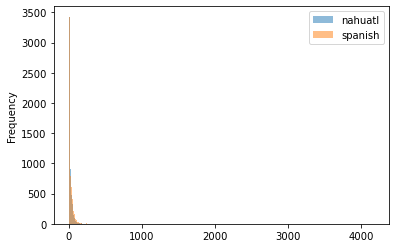

In [6]:
ax = nah_spa.plot.hist(bins=1000, alpha=0.5)

In [7]:
print('Sentences in the corpus:', nah_spa.shape[0])
print('Mean sentence lenght for Nahuatl:', np.mean(nah_spa)[0])
print('Mean sentence lenght for Spanish:', np.mean(nah_spa)[1])


Sentences in the corpus: 16145
Mean sentence lenght for Nahuatl: 21.784391452462064
Mean sentence lenght for Spanish: 29.11947971508207


In [8]:
print("Tokens in Nahuatl:",sum(nahuatl_lengths))
print("Tokens in Spanish:",sum(spanish_nahuatl_lengths))


Tokens in Nahuatl: 351709
Tokens in Spanish: 470134


The data seems to be heavly right-skewed, let's look at sentences under 200 tokens

In [9]:
nahuatl_spanish_200 = [(i,j )for i,j in zip(nahuatl_lengths, spanish_nahuatl_lengths) if i < 200]
nah_spa_200 = pd.DataFrame(nahuatl_spanish_200,columns=['Nahuatl','Spanish'])

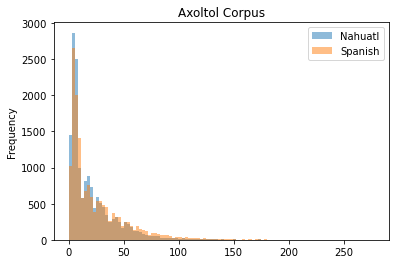

In [10]:
ax = nah_spa_200.plot.hist(bins=100, alpha=0.5, title = "Axoltol Corpus")


In [11]:
print('Sentences in Nahuatl under 200 tokens:', nah_spa_200.shape[0])
print('Mean sentence lenght for Nahuatl:', np.mean(nah_spa_200)[0])
print('Mean sentence lenght for Spanish:', np.mean(nah_spa_200)[1])


Sentences in Nahuatl under 200 tokens: 16087
Mean sentence lenght for Nahuatl: 20.421458320382918
Mean sentence lenght for Spanish: 26.005345931497484


As seen from the distribution, not that many setneces are longer than 100 tokens. In the preporcessing step we will apply subword tokenization, which will segment words into sub word units. We will truncate sentence up to the 400th character. 

# Wixarika

The Wixarika langauge is spoken by approximately 50,000 thousand people in western Mexico. This corpus is composed of translation of Grimm and Anderssen stories.

In [12]:
wixarica =open('wixarica-spanish/corpus/corpus.hch','r').readlines()
spanish_wixarica =open('wixarica-spanish/corpus/corpus.es','r').readlines()
wixarica_lengths = [len(i.split()) for i in wixarica]
spanish_wixarica_lengths = [len(i.split()) for i in spanish_wixarica]
wixarica_spanish_corpus = pd.DataFrame(zip(wixarica,spanish_wixarica, ),columns=['Wixarica','Spanish'])

In [13]:
print('Wixarica sentence:', wixarica[100])
print('Spanish translation:', spanish_wixarica[100])

Wixarica sentence: per+ temu, heiwa anunakieka yu promesa,  

Spanish translation:  Pero la rana,  una vez recibida la promesa, 



In [14]:
wix_spa = pd.DataFrame(zip(wixarica_lengths,spanish_wixarica_lengths),columns=['Wixarika','Spanish'])


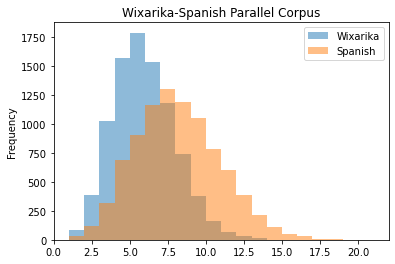

In [15]:
ax = wix_spa.plot.hist(bins=20, alpha=0.5, title = "Wixarika-Spanish Parallel Corpus")

As we can see, the distribution of sentence lenght is more unifrom the wixarica-Spanish parallel corpus than the Nahuatl-Spanish corpus. The nature of the Nahuatl-Spanish corpus might explain the distribution of sentence lengths, since there are multiple sources of variation within the data.

In [69]:
print('Sentences in the Wixarica-Spanish corpus:', wix_spa.shape[0])
print('Mean sentence lenght for Wixarica:', np.mean(wix_spa)[0])
print('Mean sentence lenght for Spanish:', np.mean(wix_spa)[1])


Sentences in the Wixarica-Spanish corpus: 8966
Mean sentence lenght for Wixarica: 5.453490965871069
Mean sentence lenght for Spanish: 7.647668971670756


In [70]:
print("Tokens in Wixarica:",sum(wixarica_lengths))
print("Tokens in Spanish:",sum(spanish_wixarica_lengths))

Tokens in Wixarica: 48896
Tokens in Spanish: 68569


# Preprocessing

Subword tokenization (Sennrich et al., 2016) has shown important advances in NMT. In this project, we use a simlar language-independent tokenizer: SentencePiece (Kudo & Richardson, 2018)

In [71]:
import sentencepiece as spm

## Nahuatl-Spanish sub-word tokenization

Since the corpus has been word tokenized, we will go ahead and start training our sentencePiece models for each language. Usuaully these models are trained on bigger chunks of data, we will instead use the provided corpora for each language. We will only perform 2000 operations as smaller number of merge operations are better for smaller datasets (Araabi and Monz, 2020). 

In [72]:

path_spm = 'nahuatl-spanish'

# train model on the source language
nahuatl_spm = spm.SentencePieceTrainer.train( input=path_spm +'/corpus/corpus.nah', 
                                         model_prefix='{}/spm/train_nah_spm'.format(path_spm),
                                         vocab_size=2000)

# train model on the target language
spanish_nahuatl_spm = spm.SentencePieceTrainer.train( input=path_spm+'/corpus/corpus.es',
                                        model_prefix='{}/spm/train_es-nah_spm'.format(path_spm),
                                         vocab_size=2000)


Load the trained model

In [73]:
#load model trained on Wixarica 
nah_pr = spm.SentencePieceProcessor()
nah_pr.load('{}/spm/train_nah_spm.model'.format(path_spm))

#load model trained on Spanish
es_nah_pr = spm.SentencePieceProcessor()
es_nah_pr.load('{}/spm/train_es-nah_spm.model'.format(path_spm))

True

Encode sentences and truncate sentences with more than 400 tokens. 

In [74]:
# Takes a pandas dataframe, returns a 2D list with subword tokenized
# parallel sentences with a max length of 400 as default

def subword_tokenization(dataset,  spm_source,  spm_target, sentence_length=400):
    # Create two lists to store the newly encoded sentences     
    source = []
    target = []

    # iterate through the initial parallel corpus
    # we need to restric our newly created sentences to 
    # a lenght of 5000 to avoid errors from the positional 
    # embedding in the transformer.

    for index,row in dataset.iterrows():

        src_e = spm_source.EncodeAsPieces(row[0])
        src_t = spm_target.EncodeAsPieces(row[1])

        #check out waht sentences have more than 400 sentence pieces
        sl = len(src_e)
        tl = len(src_t)

        source.append(' '.join(src_e[:sentence_length]))     #encode and append source sentence
        target.append(' '.join(src_t[:sentence_length]))     #encode and append target sentence
    tokenized_corpus = pd.DataFrame([(i,j )for i,j in zip(source,target)], columns = dataset.columns)
    return tokenized_corpus


In [75]:
nah_spa = subword_tokenization(dataset = nahuatl_spanish_corpus, spm_source = nah_pr, spm_target = es_nah_pr )

### Original Nahuatl-Spanish corpus

### Preprocessed Nahuatl-Spanish corpus


In [76]:
nah_spa.head(5)

,Nahuatl,Spanish
0,▁Au h ▁niman ▁y quac ▁ohual temo que ▁oaci ohu...,"▁En ▁este ▁entonces ▁baja ron ▁ , ▁lleg aron ▁..."
1,"▁Ye ▁one to co to ▁ , ▁o huilo a ▁ca ▁. ▁In ▁t...","▁Con tin ú a ▁la ▁parti da ▁de ▁gente s ▁ , ▁t..."
2,▁se ki ▁tla ka ▁ki n tla š ilia ▁ ' ▁ma xa da ▁.,▁Un as ▁personas ▁le s ▁echa n ▁es ti er co l ▁.
3,"▁Amo ▁ipampa ▁ximo tequi pacho ▁ , ▁ye ▁i ciuh...","▁No ▁de s es pe res ▁por ▁esto ▁ , ▁ya ▁mejor ..."
4,▁Pe jki ▁tle jko k ▁tle jko k,▁E m pe z ó ▁a ▁su bi r ▁y ▁su bi r


## Wixarica-Spanish subword tokenization

In [77]:
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer


As we saw above, the corpus is word tokenized as we have seen examples of words punction right next to each other. We will apply word tokenization to separate words,and numbers, from punctuation and other symbols. 

Wixarica word tokenizer

In [78]:
# Separte words and numbers from other symbols
# and spanish words
# In Wixarica '+' is a vowel

# list -> list

def wixarica_word_tokenization(dataset):
    new = []
    characters = '1234567890aehi+kmnprtsuwxy\' bcdjloqtuvzáéíóúüñ\n'
    for sentence in dataset:

        for c in sentence:
            if c not in characters:
                sentence = sentence.replace(c, ' {} '.format(c))
        sentence = " ".join(sentence.split())+"\n"

            
        new.append(sentence)
    return new

Spanish word tokenizer

In [79]:
# NLTK implementation of a Spanish word tokenizer

# list -> list

def spanish_word_tokenization(dataset):
    new = []
    word_tokenize = ToktokTokenizer()
    for sentence in dataset:
        new.append(" ".join(word_tokenize.tokenize(sentence))+'\n')
    return new
        

Separate words and numbers from other characters

In [80]:
wixarica_word_tok = wixarica_word_tokenization(dataset = wixarica )
spanish_w_word_tok = spanish_word_tokenization(dataset = spanish_wixarica)

Write the new files locally

In [81]:
with open('wixarica-spanish/corpus/word_tokenized_corpus/corpus.hch','w') as f:
    for i in wixarica_word_tok:
        f.write(i)
    

In [82]:
with open('wixarica-spanish/corpus/word_tokenized_corpus/corpus.es','w') as f:
    for i in spanish_w_word_tok:
        f.write(i)

Now, we will train a SentencePiece model with 2000 split operations. 

In [83]:
path_spm = 'wixarica-spanish'

# train model on the source language
wixarica_spm = spm.SentencePieceTrainer.train( input=path_spm+'/corpus/word_tokenized_corpus/corpus.hch', 
                                         model_prefix='{}/spm/train_hch_spm'.format(path_spm),
                                         vocab_size=2000)

# train model on the target language
spanish_wixarica_spm = spm.SentencePieceTrainer.train( input=path_spm+'/corpus/word_tokenized_corpus/corpus.es',
                                         model_prefix='{}/spm/train_es-hch_spm'.format(path_spm),
                                         vocab_size=2000)


In [84]:
#load model trained on Wixarica 
hch_pr = spm.SentencePieceProcessor()
hch_pr.load('{}/spm/train_hch_spm.model'.format(path_spm))

        
#load model trained on Spanish
es_hch_pr = spm.SentencePieceProcessor()
es_hch_pr.load('{}/spm/train_es-hch_spm.model'.format(path_spm))

True

In [85]:
wixarica_spanish_wt_corpus = pd.DataFrame(zip(wixarica_word_tok,spanish_w_word_tok, ),
                                          columns=['Wixarica','Spanish'])

In [86]:
hch_es = subword_tokenization(dataset = wixarica_spanish_wt_corpus, spm_source = hch_pr, spm_target = es_hch_pr )

In [87]:
wixarica_spanish_corpus.head(5)

,Wixarica,Spanish
0,m+k+ paukah+a tsimupe xik+ra+ye ti xuxuweme de...,ella echó la pequeña rueda de hilar de oro \n
1,"k+naya tatsiu, xeimieme, pure'eri: \n","El esposo de la liebre, sin embargo, pensó:\n"
2,"kename pinieya meta tewi heh+k+t+me ogro, \n","cuyo dueño y señor era un ogro, \n"
3,"nepexei tsipeme ki, \n","ví una pequeña casa, \n"
4,"meta mepeka uxipi naipariena cenicienta, \n","y se posaron en los hombros de Cenicienta, \n"


In [88]:
hch_es.head(5)

,Wixarica,Spanish
0,▁m + k + ▁pauka h + a ▁tsimupe ▁xik + ra + ye ...,▁ella ▁ech ó ▁la ▁pequeña ▁rueda ▁de ▁hilar ▁d...
1,"▁ k + naya ▁tatsiu ▁, ▁xeimieme ▁, ▁pure ' eri...","▁El ▁esposo ▁de ▁la ▁liebre ▁, ▁sin ▁embar go ..."
2,▁kename ▁pinieya ▁meta ▁tewi ▁heh + k + t + me...,"▁cuyo ▁dueño ▁y ▁señor ▁era ▁un ▁ o gro ▁,"
3,"▁nepe xei ▁tsipeme ▁ki ▁,","▁ v í ▁una ▁pequeña ▁casa ▁,"
4,"▁meta ▁mepeka ▁ uxipi ▁naiparie na ▁cenicienta ▁,",▁y ▁se ▁po s aron ▁en ▁lo s ▁hombro s ▁de ▁Cen...


# Separate data into training, validation, and development sets

In [89]:

#The function writes two text files, one for a src language and another for a tgt language.

def write_file(source_data, target_data, source_langauge, target_language, set_type, path ='',spm=False):
    
    src = open('{}/{}.{}'.format(path,set_type,source_langauge), 'w')
    tgt = open('{}/{}.{}'.format(path,set_type,target_language), 'w')
    
    for i in source_data:
        if spm:
            src.write(i+'\n')
        else:
            src.write(i+'\n')
    src.close() 
    for i in target_data:
        if spm:
            tgt.write(i+'\n')
        else:
            tgt.write(i+'\n')
    tgt.close()
    return


## Nauhatl-Spanish


In [90]:
# Split Train and Validation Set 
X_train_nahuatl, x_dev_nahuatl, Y_train_nahuatl, y_dev_nahuatl = train_test_split(nah_spa['Nahuatl'],
                                                                                  nah_spa['Spanish'], 
                                                                                  test_size=0.1, 
                                                                                  random_state=30)

# Split between validation test and test set
x_val_nahuatl, x_test_nahuatl, y_val_nahuatl, y_test_nahuatl = train_test_split(x_dev_nahuatl, 
                                                                                y_dev_nahuatl, 
                                                                                test_size=0.5, 
                                                                                random_state=30)


In [91]:
print( 'Size of training set:', len(X_train_nahuatl))
print( 'Size of development set:', len(x_val_nahuatl))
print( 'Size of test set:', len(x_test_nahuatl))


Size of training set: 14455
Size of development set: 803
Size of test set: 804


In [92]:
path_n = 'nahuatl-spanish/preprocessed_data/'


# write the newly created training sets
write_file(source_data = X_train_nahuatl , 
           target_data = Y_train_nahuatl ,  
           source_langauge = 'nah' , 
           target_language = 'es' ,
           set_type = 'train', 
           path = path_n, 
           spm=True )

# write the newly created training sets
write_file(source_data = x_val_nahuatl , 
           target_data = y_val_nahuatl ,  
           source_langauge = 'nah' , 
           target_language = 'es' ,
           set_type = 'val', 
           path = path_n, 
           spm=True )

# write the newly created training sets
write_file(source_data = x_test_nahuatl , 
           target_data = y_test_nahuatl ,  
           source_langauge = 'nah' , 
           target_language = 'es' ,
           set_type = 'test', 
           path = path_n, 
           spm=True )


## Wixarica-Spanish

In [93]:
# Split Train and Validation Set 
X_train_wixarica, x_dev_wixarica, Y_train_wixarica, y_dev_wixarica = train_test_split(hch_es['Wixarica'], 
                                                                                      hch_es['Spanish'], 
                                                                                      test_size=0.1, 
                                                                                      random_state=30)

# Split between validation test and test set
x_val_wixarica, x_test_wixarica, y_val_wixarica, y_test_wixarica = train_test_split(x_dev_wixarica, 
                                                                                    y_dev_wixarica, 
                                                                                    test_size=0.5, 
                                                                                    random_state=30)

In [94]:
print( 'Size of training set:', len(X_train_wixarica))
print( 'Size of development set:', len(x_val_wixarica))
print( 'Size of test set:', len(x_test_wixarica))


Size of training set: 8069
Size of development set: 448
Size of test set: 449


In [ ]:
path_n = 'wixarica-spanish/preprocessed_data/'


# write the newly created training sets
write_file(source_data = X_train_wixarica , 
           target_data = Y_train_wixarica ,  
           source_langauge = 'hch' , 
           target_language = 'es' ,
           set_type = 'train', 
           path = path_n, 
           spm=True )

# write the newly created training sets
write_file(source_data = x_val_wixarica , 
           target_data = y_val_wixarica ,  
           source_langauge = 'hch' , 
           target_language = 'es' ,
           set_type = 'val', 
           path = path_n, 
           spm=True )

# write the newly created training sets
write_file(source_data = x_test_wixarica , 
           target_data = y_test_wixarica ,  
           source_langauge = 'hch' , 
           target_language = 'es' ,
           set_type = 'test', 
           path = path_n, 
           spm=True )

# Model configurations

In [ ]:

def write_config (source_languagues, target_languages, model_type = 'seq2seq'):
   

    save = """# {}.yaml

    ## Where the samples will be written
    save_data: {}-{}/{}/"""



    writen = """ 

    ## Where the vocab(s) will be written
    src_vocab: {}-{}/{}/vocabulary/vocab.src
    tgt_vocab: {}-{}/{}/vocabulary/vocab.tgt
    # Prevent overwriting existing files in the folder
    overwrite: False"""


    data = """

    # Corpus opts:
    data:
        corpus_1:
            path_src: {}-{}/preprocessed_data/train.{}
            path_tgt: {}-{}/preprocessed_data/train.{}
        valid:
            path_src: {}-{}/preprocessed_data/val.{}
            path_tgt: {}-{}/preprocessed_data/val.{}
    """

    hyp_1 = '''# General opts
    save_model: {}-{}/{}/steps/{}
    save_checkpoint_steps: 1000
    valid_steps: 1000
    train_steps: 35000

    # Batching
    queue_size: 8
    bucket_size: 8
    world_size: 1
    gpu_ranks: [0]
    batch_type: "sents"
    batch_size: 8
    valid_batch_size: 8
    max_generator_batches: 2
    accum_count: [4]
    accum_steps: [0]

    # Optimization
    model_dtype: "fp32"
    optim: "adam"
    learning_rate: 1
    warmup_steps: 4000
    decay_method: "noam"
    adam_beta2: 0.998
    max_grad_norm: 0
    label_smoothing: 0.1
    param_init: 0
    param_init_glorot: true
    normalization: "sents"
    '''
    s2s = """
    # General opts
    save_model: {}-{}/{}/steps/{}
    save_checkpoint_steps: 1000
    valid_steps: 1000
    train_steps: 35000

    # Batching
    batch_size: 8

    #GPU
    world_size: 1
    gpu_ranks: [0]"""



    FFN = [512, 1024] 

    hyp_2 = """# Model
    encoder_type: transformer
    decoder_type: transformer
    position_encoding: true
    enc_layers: 3
    dec_layers: 3
    heads: 4
    rnn_size: 128
    word_vec_size: 128
    transformer_ff: {}
    dropout_steps: [0]
    dropout: [0.3]
    attention_dropout: [0.3]
    """
    log = '''
    # Logging
    log_file: {}-{}/{}/log_{}
    ...
    '''
    
    for src in source_languagues:
        for tgt in target_languages: 
            if model_type == 'transformer': 
                for ffn in [512, 1024] :
                    model = 'transformer_{}'.format(ffn)

                    config_path = '{}-{}/{}'.format(src,tgt, model)

                    config = [save.format(model,src,tgt, model),
                    writen.format(src,tgt, model, src,tgt, model),
                    data.format(src,tgt, langauges[src], 
                    src,tgt, langauges[tgt], 
                    src,tgt, langauges[src], 
                    src,tgt, langauges[tgt]),
                    hyp_1.format(src,tgt, model, model),
                    hyp_2.format(ffn),
                    log.format(src,tgt, model, model)
                    ]

            if model_type == 'seq2seq':
                model = 'seq2seq'

                config_path = '{}-{}/{}'.format(src,tgt, model)

                config = [save.format(model,src,tgt, model),
                writen.format(src,tgt, model, src,tgt, model),


                data.format(src,tgt, langauges[src], 
                src,tgt, langauges[tgt], 
                src,tgt, langauges[src], 
                src,tgt, langauges[tgt]),
                s2s.format(src,tgt, model, model),
                log.format(src,tgt, model, model)
                ]

                
            with open(config_path+'.yaml', 'w') as f:
                f.write(''.join(config))


In [ ]:
write_config(source_languagues = ['spanish'], 
                          target_languages = ['wixarica', 'nahuatl'], 
                          model_type = 'seq2seq')

In [ ]:
write_config(source_languagues = ['spanish'], 
                          target_languages = ['wixarica', 'nahuatl'], 
                          model_type = 'transformer')

In [ ]:
write_config(source_languagues = ['wixarica', 'nahuatl'] , 
                          target_languages = ['spanish'],
                          model_type = 'seq2seq')

In [ ]:
write_config(source_languagues = ['wixarica', 'nahuatl'] , 
                          target_languages = ['spanish'],
                          model_type = 'transformer')


# Training

In [ ]:
!pip install OpenNMT-py

# Polysynthetic to Fusional 

# LSTM

In [ ]:
!onmt_build_vocab -config nahuatl-spanish/configurations/seq2seq.yaml -n_sample 2000
!onmt_train -config nahuatl-spanish/configurations/seq2seq.yaml

In [ ]:
!onmt_build_vocab -config wixarica-spanish/configurations/seq2seq.yaml -n_sample 2000
!onmt_train -config wixarica-spanish/configurations/seq2seq.yaml

# Transformer 512 

In [ ]:
!onmt_build_vocab -config nahuatl-spanish/configurations/transformer_512.yaml -n_sample 2000
!onmt_train -config nahuatl-spanish/configurations/transformer_512.yaml

In [ ]:
!onmt_build_vocab -config wixarica-spanish/configurations/transformer_512.yaml -n_sample 2000
!onmt_train -config wixarica-spanish/configurations/transformer_512.yaml

# Transformer 1024

In [ ]:
!onmt_build_vocab -config nahuatl-spanish/configurations/transformer_1024.yaml -n_sample 2000
!onmt_train -config nahuatl-spanish/configurations/transformer_1024.yaml

In [ ]:
!onmt_build_vocab -config wixarica-spanish/configurations/transformer_1024.yaml -n_sample 2000
!onmt_train -config wixarica-spanish/configurations/transformer_1024.yaml

# Fusional to polysynthetic

## LSTM

In [ ]:
!onmt_build_vocab -config spanish-nahuatl/configurations/seq2seq.yaml -n_sample 2000
!onmt_train -config spanish-nahuatl/configurations/seq2seq.yaml

In [ ]:
!onmt_build_vocab -config spanish-wixarica/configurations/seq2seq.yaml -n_sample 2000
!onmt_train -config spanish-wixarica/configurations/seq2seq.yaml

## Transformer 512

In [ ]:
!onmt_build_vocab -config spanish-nahuatl/configurations/transformer_512.yaml -n_sample 2000
!onmt_train -config spanish-nahuatl/configurations/transformer_512.yaml

In [ ]:
!onmt_build_vocab -config spanish-wixarica/configurations/transformer_512.yaml -n_sample 2000
!onmt_train -config spanish-wixarica/configurations/transformer_512.yaml

## Transformer 1024

In [ ]:
!onmt_build_vocab -config spanish-nahuatl/configurations/transformer_1024.yaml -n_sample 2000
!onmt_train -config spanish-nahuatl/configurations/transformer_1024.yaml

In [ ]:
!onmt_build_vocab -config spanish-wixarica/configurations/transformer_1024.yaml -n_sample 2000
!onmt_train -config spanish-wixarica/configurations/transformer_1024.yaml

# Evaluation

In [ ]:
#Translate sentences in the test set using the learend models
def translate_sentences(langauges, model, iterations = 36000):
    langs = {'wixarica':'hch', 'nahuatl':'nah', 'spanish':'es'}
    l = langauges.split('-')[0]
    test_subset = langs[l]
    
    for i in range(1000,iterations,1000):
        m = langauges+'/'+model+'/steps/'+model+'_step_{}.pt'.format(i)
        s = langauges+'/preprocessed_data/test.{}'.format(test_subset) 
        outp = langauges+'/'+model+'/predictions/actual_pred_{}.txt'.format(i)
        translate = 'onmt_translate -model {} -src {} -output {} -gpu 0'.format(m,s,outp)
        os.system(translate)
        print(model,i,'for',langauges, 'done!')
        
    return

In [ ]:

import sacrebleu

# functions to evaluate a single sentence

def calculate_score_report(prediction, reference, score_only=True):
    #compute chrf
    chrf = sacrebleu.corpus_chrf(prediction, reference)
    #compute bleu
    bleu = sacrebleu.corpus_bleu(prediction, reference)
    
    b = float(bleu.format(score_only=score_only))
    c = float(str(chrf)[8:])
    return (c,b)

# functions to multiple sentences

def evaluate_performance (reference, prediction):
    bleu = []
    chrf = []
    for ref,pred in zip(reference,prediction):
        score = list(calculate_score_report( pred, ref, score_only=True))
        chrf.append(score[0])
        bleu.append(score[1])
    return([bleu,chrf])

In [ ]:
def model_evaluation(langauges, model, iterations = 36000):
    path = '{}/{}'.format(languages, model)
    l = langauges.split('-')[0]
    test_subset = langs[l]
    
    references = open('{}/preprocessed_data/test.{}'.format(languages, test_subset),'r').readlines()
    predictions = {}
    for i in range(1000,iterations,1000):
        preds = open(path+'/predictions/actual_pred_{}.txt'.format(i),'r').readlines()
        predictions['pred_{}'.format(i)] = evaluate_performance (references, preds)

    with open('{}_actual_pred__evaluation.txt'.format(path), 'w') as evaluation:

        for i in predictions:
            pr = predictions[i]
            blue,chrf = pr[0],pr[1]
            evaluation.write(i+'\n')
            evaluation.write('BLEU:{}'.format(sum(blue)/len(blue))+'\n')
            evaluation.write('CHRF:{}'.format(sum(chrf)/len(chrf))+'\n')
    return

## Polysyntethic to Fusional

### LSTM

In [ ]:
translate_sentences(langauges = 'nahuatl-spanish', model = 'seq2seq')
model_evaluation(langauges = 'nahuatl-spanish', model = 'seq2seq')

In [ ]:
translate_sentences(langauges = 'wixarica-spanish', model = 'seq2seq')
model_evaluation(langauges = 'wixarica-spanish', model = 'seq2seq')

### Transformer-512

In [ ]:
translate_sentences(langauges = 'nahuatl-spanish', model = 'transformer_512')
model_evaluation(langauges = 'nahuatl-spanish', model = 'transformer_512')

In [ ]:
translate_sentences(langauges = 'wixarica-spanish', model = 'transformer_512')
model_evaluation(langauges = 'wixarica-spanish', model = 'transformer_512')

### Transformer-1024

In [ ]:
translate_sentences(langauges = 'nahuatl-spanish', model = 'transformer_1024')
model_evaluation(langauges = 'nahuatl-spanish', model = 'transformer_1024')

In [ ]:
translate_sentences(langauges = 'wixarica-spanish', model = 'transformer_1024')
model_evaluation(langauges = 'wixarica-spanish', model = 'transformer_1024')

## Fusional to polysynthetic

### LSTM

In [ ]:
translate_sentences(langauges = 'spanish-nahuatl', model = 'seq2seq')
model_evaluation(langauges = 'spanish-nahuatl', model = 'seq2seq')

In [ ]:
translate_sentences(langauges = 'spanish-wixarica', model = 'seq2seq')
model_evaluation(langauges = 'spanish-wixarica', model = 'seq2seq')

### Transformer 512

In [ ]:
translate_sentences(langauges = 'spanish-nahuatl', model = 'transformer_512')
model_evaluation(langauges = 'spanish-nahuatl', model = 'transformer_512')

In [ ]:
translate_sentences(langauges = 'spanish-wixarica', model = 'transformer_512')
model_evaluation(langauges = 'spanish-wixarica', model = 'transformer_512')

### Transformer 1024

In [ ]:
translate_sentences(langauges = 'spanish-nahuatl', model = 'transformer_1024')
model_evaluation(langauges = 'spanish-nahuatl', model = 'transformer_1024')

In [ ]:
translate_sentences(langauges = 'spanish-wixarica', model = 'transformer_1024')
model_evaluation(langauges = 'spanish-wixarica', model = 'transformer_1024')